In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

Images downloaded from :

https://www.freepik.com/free-photo/multiracial-group-young-people-taking-selfie_1174271.htm#query=people&position=45&from_view=keyword&track=sph

https://www.vhv.rs/viewpic/wxwwh_smiley-face-png-transparent-png/

In [2]:
file_1 = 'people.jpg'
file_2 = 'happy_face.jpg'

In [3]:
people = cv2.imread(file_1)
smile_face = cv2.imread(file_2)

In [4]:
def show_image(image):
    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
show_image(people)
show_image(smile_face)

In [6]:
people.shape, smile_face.shape

((4912, 7360, 3), (400, 400, 3))

In [7]:
image = people.copy()

In [8]:
image = cv2.resize(people, (people.shape[1]//4,people.shape[0]//4), interpolation = cv2.INTER_NEAREST)

In [9]:
model = 'deploy.prototxt'
weights = 'res10_300x300_ssd_iter_140000.caffemodel'

In [10]:
net = cv2.dnn.readNetFromCaffe(model, weights)

In [11]:
input_size = (300, 300)
scale_factor = 1.0

In [12]:
blob = cv2.dnn.blobFromImage(image, scale_factor, input_size, (0, 0, 0), swapRB=False, crop=False)

In [13]:
net.setInput(blob)

In [14]:
detections = net.forward()

In [15]:
def extract_face(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     ret,thresh_img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
#     contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     sorted_contours = sorted(contours, key=lambda c: len(c), reverse=True)
#     longest_contour = sorted_contours[0]
           
    mask = np.zeros(image.shape[:2], dtype = np.uint8)
    cv2.circle(mask,(200,200), 199, (255,255,255), -1)
    mask_inv = cv2.bitwise_not(mask)
    
#     mask = cv2.drawContours(mask, [longest_contour], 0, (0,0,0), -1)
    
    return mask, mask_inv

In [16]:
mask, mask_inv = extract_face(smile_face)

In [17]:
show_image(mask)
show_image(mask_inv)

In [20]:
def anonymize(image, type_anonymize, smile_face = None):

    img = image.copy()
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            #cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
            
            temp_image = img[startY:endY, startX:endX]     
            
            # Type "0" - blurring the faces
            if type_anonymize == 0:
                blurred = cv2.GaussianBlur(temp_image, (45,45),80)
                img[startY:endY, startX:endX] = blurred
            
            # Type "1" - pixelation of the faces
            if type_anonymize == 1:
                downsized_pixelized = cv2.resize(temp_image, (temp_image.shape[1]//25, temp_image.shape[0]//25), interpolation = cv2.INTER_NEAREST)
                upsized_pixelized = cv2.resize(downsized_pixelized, (temp_image.shape[1], temp_image.shape[0]))
                img[startY:endY, startX:endX] = upsized_pixelized 
                
            # Type "2" - replacement
            try: 
                if type_anonymize == 2:
                    img[startY:endY, startX:endX] = cv2.resize(smile_face,(temp_image.shape[1], temp_image.shape[0]), interpolation = cv2.INTER_NEAREST)
            except:
                print("Check the variables, something seems not to correct!")
                
            # Type "3" - replacement shaped 
            try:
                if type_anonymize == 3:
                    mask, mask_inv = extract_face(smile_face)
                    temp_face = cv2.resize(smile_face,(temp_image.shape[1], temp_image.shape[0]))

                    mask = cv2.resize(mask,(temp_image.shape[1], temp_image.shape[0]))
                    mask_inv = cv2.resize(mask_inv,(temp_image.shape[1], temp_image.shape[0]))

                    fg = cv2.bitwise_and(img[startY:endY, startX:endX], img[startY:endY, startX:endX], mask=mask_inv)
                    bg = cv2.bitwise_and(temp_face, temp_face, mask=mask)

                    img[startY:endY, startX:endX] = cv2.add(fg, bg)
            except:
                print("Check the variables, something seems not to be correct!")
                                
    return img

### Blurring face efect

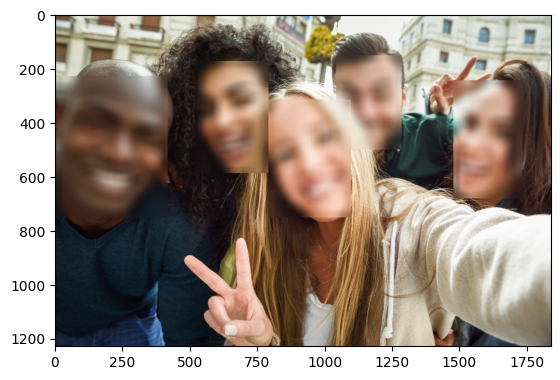

In [21]:
type_1 = anonymize(image, 0)
plt.imshow(cv2.cvtColor(type_1, cv2.COLOR_BGR2RGB))
plt.show()

### Pixelation face effect

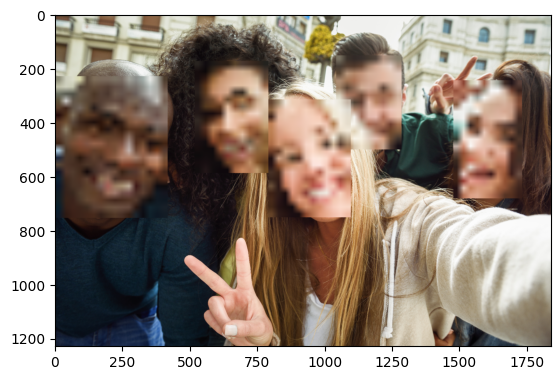

In [22]:
type_2 = anonymize(image, 1)
plt.imshow(cv2.cvtColor(type_2, cv2.COLOR_BGR2RGB))
plt.show()

### Smile Face replacement effect (not complete)

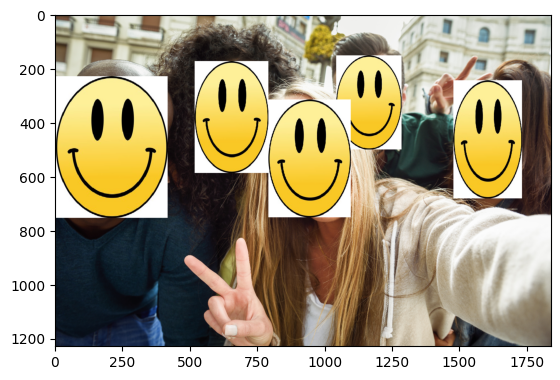

In [23]:
type_3 = anonymize(image, 2, smile_face)
plt.imshow(cv2.cvtColor(type_3, cv2.COLOR_BGR2RGB))
plt.show()

### Smile Face replacement effect

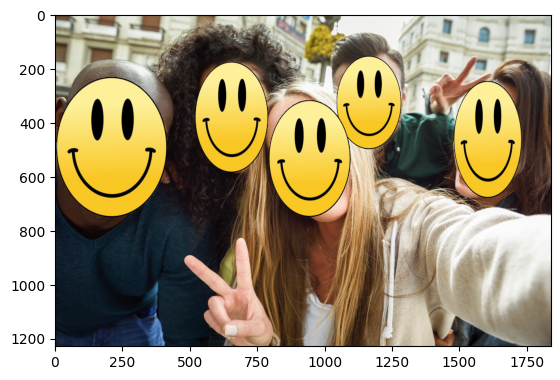

In [24]:
type_4 = anonymize(image, 3, smile_face)
plt.imshow(cv2.cvtColor(type_4, cv2.COLOR_BGR2RGB))
plt.show()